# Survival Analysis - zscores

author: emile esmaili

## Imports

In [552]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.facecolor'] = 'white'
warnings.filterwarnings("ignore")

from sksurv.preprocessing import OneHotEncoder

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns
from sklearn.linear_model import LassoCV
import xgboost as xgb
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from umap import UMAP

import shap
from Bio import Entrez
import re
from IPython.display import display, Markdown, Latex

## Cleaning, Preprocessing

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")

In [3]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


In [4]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 514 samples in total, and there are 20531 genes in total.


In [5]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()


If there is NA values: True


In [6]:
# thus, we need to drop all of same_value_cols: 
df_clean = df_clean.drop(same_value_cols, axis = 1)
df_clean = df_clean.dropna(axis=1)
df_clean = df_clean.add_prefix('gene_')

In [7]:
adata= sc.AnnData(df_clean)

normalizing counts per cell
    finished (0:00:00)


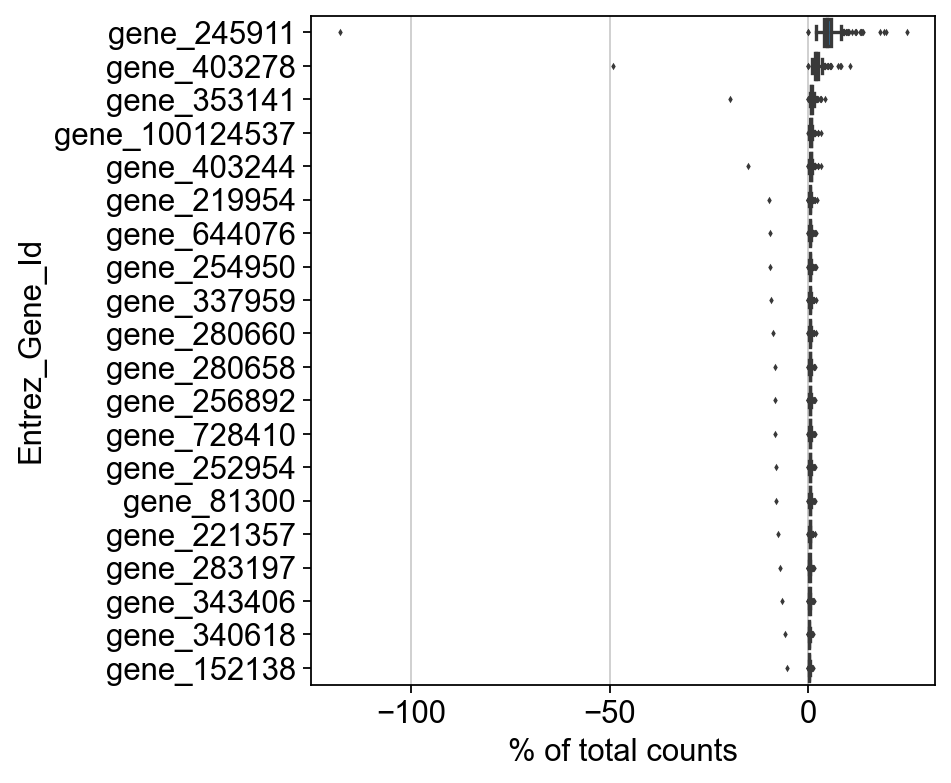

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

Clustering

computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


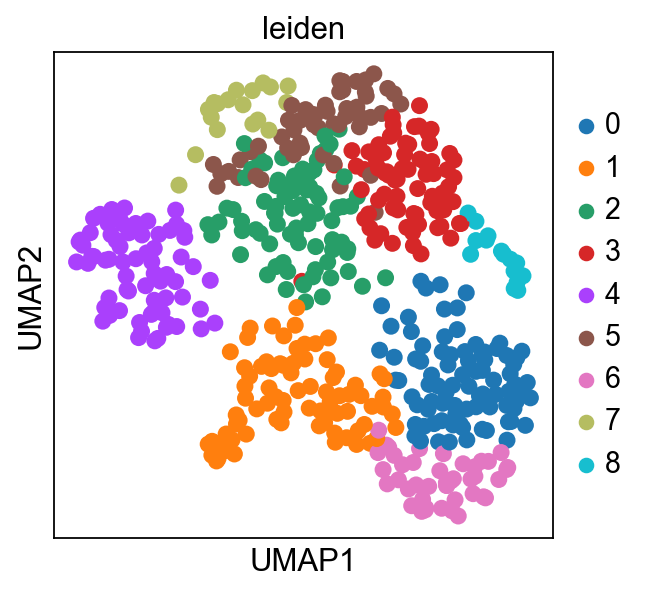

In [9]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [10]:
print("Explained variance of PCA:" , adata.uns['pca']['variance_ratio'].sum())

Explained variance of PCA: 0.7036328


In [11]:
clusters_df = pd.DataFrame(adata.obs['leiden']).reset_index(level=0)
clusters_df['index'] = clusters_df['index'].str[:-3]

Clinical Patient Data

In [12]:
data_patient = pd.read_table('data/data_clinical_patient.txt', sep='\t')
print(data_patient.iloc[0])


#Patient Identifier                                                                                   #Identifier to uniquely specify a patient.
Subtype                                                                                                                                  Subtype
TCGA PanCanAtlas Cancer Type Acronym                                                           Text field to hold cancer type acronym used by...
Other Patient ID                                                                                         Legacy DMP patient identifier (DMPnnnn)
Diagnosis Age                                                                                  Age at which a condition or disease was first ...
Sex                                                                                                                                          Sex
Neoplasm Disease Stage American Joint Committee on Cancer Code                                 The extent of a cancer, especially 

In [13]:
data_patient = data_patient.drop([0,1,2,3], axis = 0)
df_patient = data_patient.reset_index(drop=True)

In [14]:
df_patient.head(3)

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Patient Weight,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months)
0,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,31,Female,NaN,NaN,3574,-11509,...,NaN,Yes,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,NaN,NaN,0:CENSORED,117.5000822
1,TCGA-CS-4941,LGG_IDHwt,LGG,fc222f23-b3b2-4ac0-bc61-e8e8fa5cc160,67,Male,NaN,NaN,NaN,-24578,...,NaN,Yes,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,NaN,NaN,1:PROGRESSION,0.295887168
2,TCGA-CS-4942,LGG_IDHmut-non-codel,LGG,230f5fa7-aa36-41ea-b40b-08f520767bd5,44,Female,NaN,NaN,NaN,-16297,...,NaN,Yes,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,NaN,NaN,1:PROGRESSION,38.92560082


Adding statistical clusters to patient data

In [15]:
df_patient_clusters = pd.merge(left=df_patient, right=clusters_df, left_on='#Patient Identifier', right_on="index")

In [16]:
droper = ['Other Patient ID',  'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Last Communication Contact from Initial Pathologic Diagnosis Date','Form completion date',
       'Informed consent verified','Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',  
        'New Neoplasm Event Post Initial Therapy Indicator',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Tumor Stage Code',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Disease Free Status', "Patient Weight",
       'Disease Free (Months)', 'Ethnicity Category','Primary Lymph Node Presentation Assessment',
       'index','Progress Free Survival (Months)', 'Months of disease-specific survival',
        'Disease-specific Survival status', 'Progression Free Status'

       ]

In [17]:
df_patient_clusters = df_patient_clusters.drop(droper, axis=1).reset_index(drop=True)

Adding genes to patient data

In [18]:
df_clean['ID'] = df_clean.index
df_clean['ID'] = df_clean['ID'].str[:-3]


In [19]:
binary_columns = ['Overall Survival Status']
for col in binary_columns:
    df_patient_clusters[col] = pd.to_numeric(df_patient_clusters[col].str[0])

Encoding

In [20]:
df_patient_clusters['Person Neoplasm Cancer Status'] = df_patient_clusters['Person Neoplasm Cancer Status'].map({'With Tumor': 1, 'Tumor Free': 0})
df_patient_clusters['Prior Diagnosis'] = df_patient_clusters['Prior Diagnosis'].map({'Yes': 1, 'No': 0})
df_patient_clusters['Radiation Therapy'] = df_patient_clusters['Radiation Therapy'].map({'Yes': 1, 'No': 0})
df_patient_clusters['In PanCan Pathway Analysis'] = df_patient_clusters['In PanCan Pathway Analysis'].map({'Yes': 1, 'No': 0})
df_patient_clusters['Sex'] = df_patient_clusters['Sex'].map({'Male': 1, 'Female': 0})

In [21]:
# perform one-hot encoding 
cat_data = ['Race Category','Subtype']
df_patient_clusters_enc = df_patient_clusters
for feature in cat_data:
    encoded_df = pd.get_dummies(df_patient_clusters_enc[feature])
    # cncatenate the original dataframe with the encoded dataframe
    df_patient_clusters_enc = pd.concat([df_patient_clusters_enc, encoded_df], axis=1)
    # drop the original categorical column
df_patient_clusters_enc.drop(cat_data, axis=1, inplace=True)

In [22]:
df_genes = df_clean
df_genes['ID'] = df_genes.index.str[:-3]
df_genes = df_genes.reset_index(drop=True)

In [37]:
df_patient_clusters_enc['Overall Survival Status'] = df_patient_clusters_enc['Overall Survival Status'].fillna(df_patient_clusters_enc['Overall Survival Status'].mode()[0])
df_patient_clusters_enc['Overall Survival (Months)'] = df_patient_clusters_enc['Overall Survival (Months)'].fillna(df_patient_clusters_enc['Overall Survival (Months)'].median())
df_patient_clusters_enc['Sex'] = df_patient_clusters_enc['Sex'].fillna(df_patient_clusters_enc['Sex'].mode()[0])

feature selection with mutual info

In [56]:
from sklearn.feature_selection import mutual_info_regression
# create a dataframe containing mutual information for each feature
var = ['Overall Survival (Months)', 'Overall Survival Status']
midf = pd.DataFrame({
    "feature": df_genes.drop('ID', axis=1).columns.values,
    "mi": mutual_info_regression(df_genes.drop('ID', axis=1).values, df_patient_clusters_enc[var[0]].astype(float).values),
}).sort_values("mi", ascending=False)

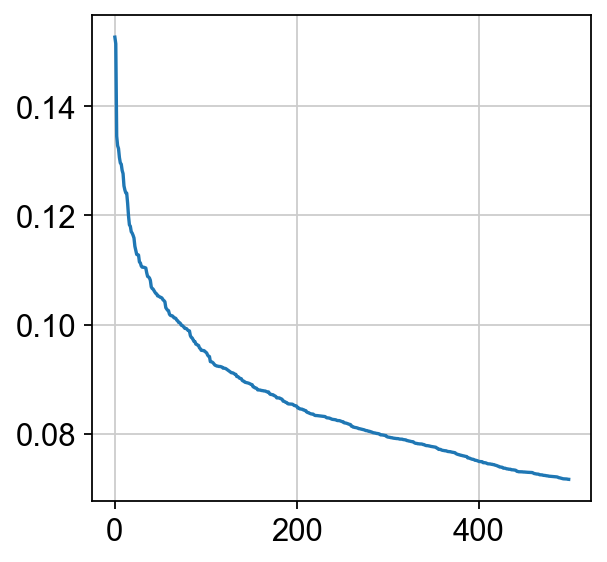

In [58]:
plt.plot(np.arange(500), midf.mi.iloc[:500])

In [160]:
selected_genes = midf.loc[midf.mi >= 0.08, "feature"]
len(selected_genes)

290

In [222]:
df_genes_select = df_genes[list(selected_genes)+['ID']]

In [223]:
df_ML = pd.merge(df_patient_clusters_enc, df_genes_select, left_on='#Patient Identifier', right_on='ID').drop('ID', axis=1)
df_ML= df_ML.loc[:, ~df_ML.columns.duplicated()].drop('#Patient Identifier', axis=1)


 Preprocessing

In [224]:

def preproc(X):
    categorical = ['Sex','Person Neoplasm Cancer Status', 'Prior Diagnosis',
                            'Radiation Therapy','In PanCan Pathway Analysis', 'American Indian or Alaska Native','White',
                            'Asian','Black or African American','LGG_IDHmut-codel','LGG_IDHmut-non-codel','LGG_IDHwt',
                            'Overall Survival Status',
                            ]

    categorical_features = list(set(categorical) & set(X.columns))
    numeric_features = X.drop(categorical_features, axis=1,errors='raise')
    numeric_features = numeric_features.columns.tolist()


    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
        ])

    #Replacing missing values with Modal value and then one hot encoding.
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ])

    preprocessor = ColumnTransformer(transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
                ])
    return preprocessor.fit_transform(X)


In [225]:
var = ['Overall Survival (Months)', 'Overall Survival Status']
X = df_ML.drop(var, axis=1).reset_index(drop=True)


In [226]:
X_sample = X.sample(frac=0.9, axis=1 )
#X = X_sample

## 🏆 Survival Models

In [227]:
y_surv = pd.concat([df_ML['Overall Survival Status'].astype(bool), df_ML['Overall Survival (Months)'].apply(pd.to_numeric)], axis=1).to_records(index=False)
X_surv = preproc(X)

In [228]:
X_train, X_test, y_train, y_test = train_test_split(
    X_surv, y_surv, random_state=42)

### RF and Boosting 

In [374]:
random_state = 666

In [490]:
booster = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=random_state
)
booster.fit(X_train, y_train)


GradientBoostingSurvivalAnalysis(learning_rate=1, max_depth=1, random_state=666)

In [491]:
print("Train score: {:.3f}".format(booster.score(X_train, y_train)), "\nTest score: {:.3f}".format(booster.score(X_test, y_test)))

Train score: 0.987 
Test score: 0.842


In [496]:
rf = RandomSurvivalForest(n_estimators=100,
                           #min_samples_split=10,
                           #min_samples_leaf=10,
                           n_jobs=-1,
                           random_state=random_state)
rf.fit(X_train, y_train)


RandomSurvivalForest(n_jobs=-1, random_state=666)

In [497]:
print("Train score: {:.3f}".format(rf.score(X_train, y_train)), "\nTest score: {:.3f}".format(rf.score(X_test, y_test)))

Train score: 0.960 
Test score: 0.853


### Elastic Net Cox Model

In [416]:
cox_net = CoxnetSurvivalAnalysis(l1_ratio= 0.9,
                                  alpha_min_ratio= 0.25,
                                    fit_baseline_model=True)
cox_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, fit_baseline_model=True,
                       l1_ratio=0.9)

In [452]:
cv=False
cv2=False

In [473]:
if cv==True:
    cox_elastic_net = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    params = {'l1_ratio':np.arange(0.1,1.05,0.05), "alpha_min_ratio":np.arange(0.1,1.05,0.05)}
    cox_net_cv = GridSearchCV(cox_elastic_net,
                        param_grid=params,
                        n_jobs=-1,
                        cv=5,
                        )
    cox_net_cv.fit(X_train, y_train)
    #extract best score and parameter by calling objects "best_score_" and "best_params_"
    print("best mean cross-validation score: {:.3f}".format(cox_net_cv.best_score_))
    print("best parameters: {}".format(cox_net_cv.best_params_))
    print("Train score: {:.3f}".format(cox_net_cv.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net_cv.score(X_test, y_test)))
    cox_net = cox_net_cv.best_estimator_

best mean cross-validation score: 0.874
best parameters: {'alpha_min_ratio': 0.1, 'l1_ratio': 0.1}
Train score: 0.907 
Test score: 0.854


In [474]:
if cv2==True:
    estimated_alphas = cox_net.alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.25, fit_baseline_model=True)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=-1)
    gcv.fit(X_train, y_train)
    cox_net = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

In [475]:
print("Train score: {:.3f}".format(cox_net.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net.score(X_test, y_test)))

Train score: 0.907 
Test score: 0.854


#### Feature Importance

In [524]:
def plot_coef(model,labels,k=15,proj=None, return_results=False, plot=True):

    if proj==None:
        coef = model.coef_
    else:
        coef_proj  =  model.coef_[:,-1].reshape(-1,1)
        coef = proj.inverse_transform(coef_proj.T).T
        
    best_coefs = pd.DataFrame(
        coef[:,-1],
        index=labels,
        columns=["coefficient"]
    )
    non_zero = np.sum(best_coefs.iloc[:, 0] != 0)

    non_zero_coefs = best_coefs.query("coefficient != 0")
    coef_order = non_zero_coefs.abs().sort_values("coefficient").index
    alpha = round(model.alphas_[-1],2)
    top_features = non_zero_coefs.loc[coef_order]['coefficient'].tail(k)
    if plot==True:
        print("Number of non-zero coefficients: {}".format(non_zero))
        _, ax = plt.subplots(figsize=(6, 6))
        top_features.plot.barh(ax=ax, legend=False)
        ax.set_xlabel("coefficient")
        ax.set_title(f'Top {k} features (z-score data), $\\alpha={alpha} $')
        ax.grid(True)
    if return_results ==True:
        return top_features, top_features.index

Number of non-zero coefficients: 78


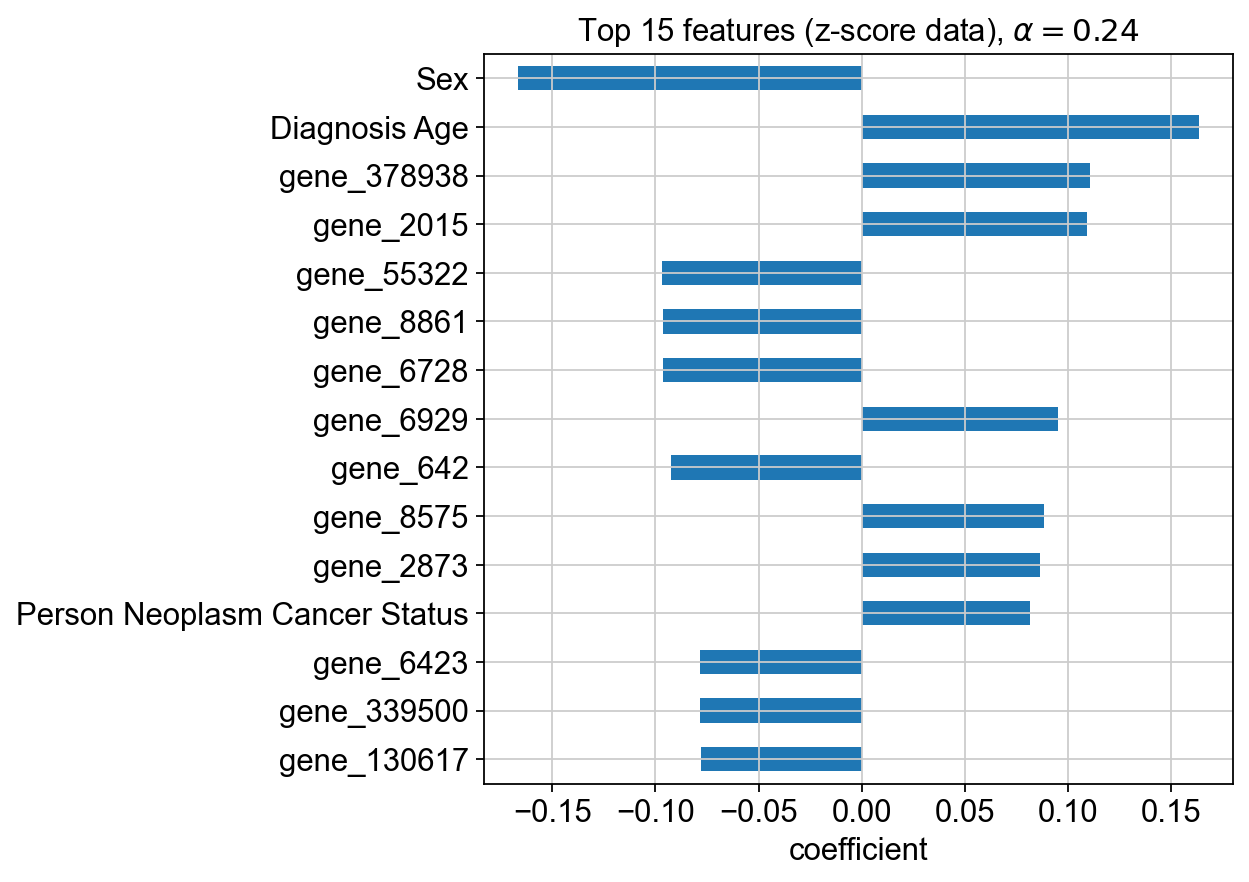

In [525]:
plot_coef(cox_net, X.columns)

#### Survival Curves

Text(0.5, 0, 'time $t$')

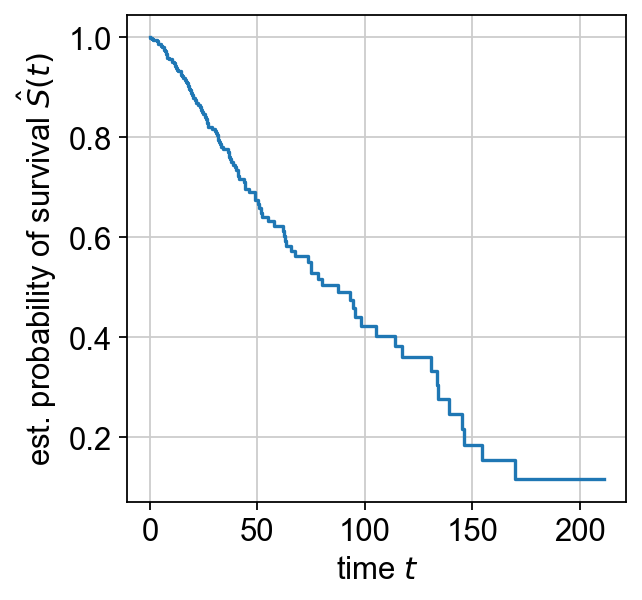

In [478]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(df_ML["Overall Survival Status"].astype(bool), df_ML['Overall Survival (Months)'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [479]:
def df_from_rec(y_surv_df):
    # Convert y_surv back to a DataFrame
    y_surv_df = pd.DataFrame(y_surv_df, columns=['Overall Survival Status', 'Overall Survival (Months)'])

    # Separate the columns into two DataFrames
    df_ML_recovered = pd.DataFrame(y_surv_df['Overall Survival Status'])
    df_ML_recovered['Overall Survival (Months)'] = y_surv_df['Overall Survival (Months)']

    return df_ML_recovered['Overall Survival Status'], df_ML_recovered['Overall Survival (Months)']

In [480]:
def plot_surv_curves(X_train, y_train, X_test, y_test, model):

    survival_function_test = model.predict_survival_function(X_test, return_array=False)
    survival_function_train = model.predict_survival_function(X_train, return_array=False)
    score_test = model.score(X_test, y_test)
    score_train = model.score(X_train, y_train)

    fig, ax = plt.subplots(1,2, figsize=(10,4))

    for i, (a, b) in enumerate(y_train):
        ax[0].plot(survival_function_train[i].x, survival_function_train[i].y, alpha=0.05, c='blue')
    for i, (a, b) in enumerate(y_test):
        ax[1].plot(survival_function_test[i].x, survival_function_test[i].y, alpha=0.05, c='blue')

    y_hat_train = np.array([s.y for s in survival_function_train])  # Extract y values from step functions
    avg_survival_train = np.mean(y_hat_train, axis=0) 

    y_hat_test = np.array([s.y for s in survival_function_test])  # Extract y values from step functions
    avg_survival_test = np.mean(y_hat_train, axis=0) 

    ax[0].plot(survival_function_train[0].x, avg_survival_train, alpha=1, c='red', label='model average')
    ax[1].plot(survival_function_test[0].x, avg_survival_test, alpha=1, c='red', label='model average')

    # KM
    status_train, time_train = df_from_rec(y_train)
    time_cell, survival_prob_cell = kaplan_meier_estimator(status_train.astype(bool),
                                                            time_train)        
    ax[0].plot(time_cell, survival_prob_cell,
                   label='Kaplan Meier', c='black'
                   )
    
    status_test, time_test = df_from_rec(y_test)
    time_cell, survival_prob_cell = kaplan_meier_estimator(status_test.astype(bool),
                                                            time_test)        
    ax[1].plot(time_cell, survival_prob_cell,
                   label='Kaplan Meier', c='black'
                   )

    fig.supxlabel('Time')
    fig.supylabel('Survival probability')

    ax[0].set_title(f'Train Predicted Survival Curves (Score={score_train:.3f})')
    ax[1].set_title(f'Test Predicted Survival Curves (Score={score_test:.3f})')
    plt.legend()
    plt.show()


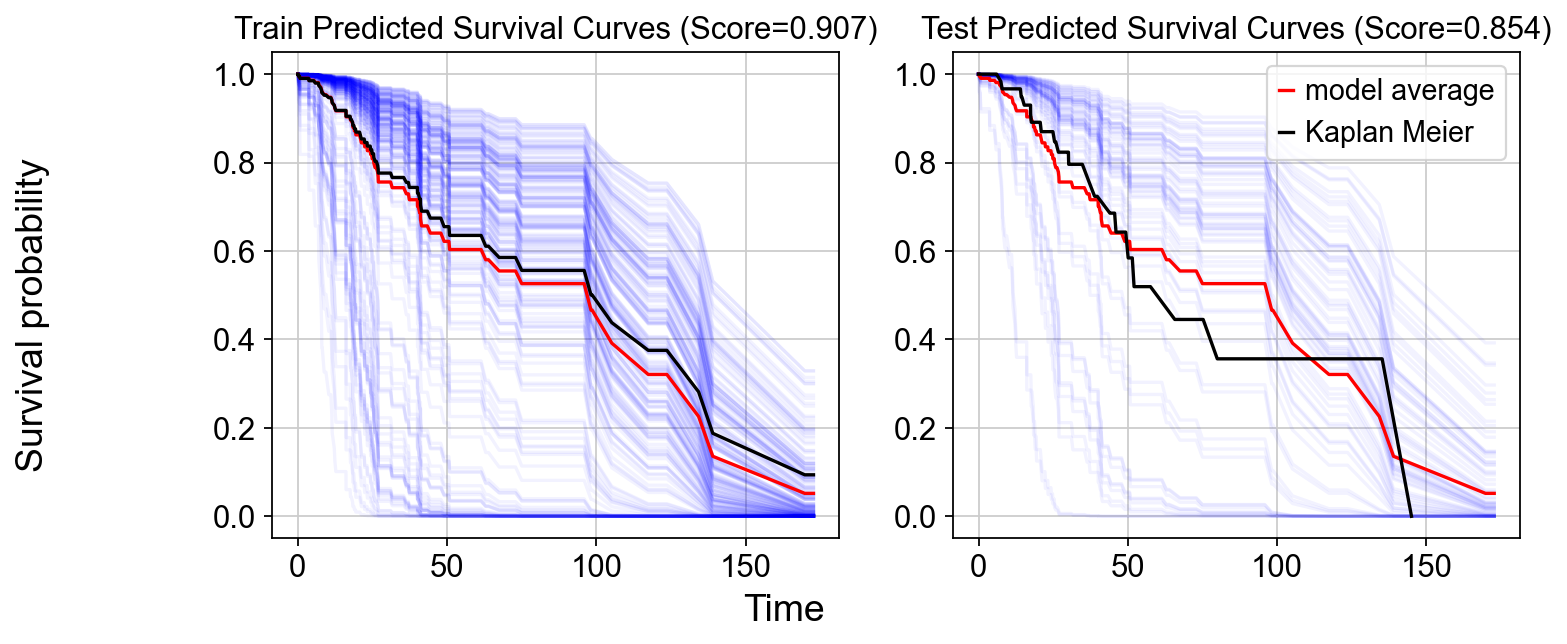

In [481]:
plot_surv_curves(X_train, y_train, X_test, y_test, cox_net)

#### Exploration:  PCA Elastic Net Model 

In [482]:
n=50

pca_train = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True)
pca_test = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True)

X_train_pca = pca_train.fit_transform(X_train)
X_test_pca = pca_test.fit_transform(X_test)
y_train_pca = y_train
y_test_pca = y_test


In [483]:
n = 50
pca = KernelPCA(n_components=n,
                 kernel='rbf',
                 degree=5,
                 #gamma=1e-7,
                 fit_inverse_transform=True)
umap = UMAP()
tsne = TSNE()
proj = pca
X_pca = proj.fit_transform(X_surv)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_surv, random_state=42)

In [484]:
cox_net2 = CoxnetSurvivalAnalysis(l1_ratio= 0.9,
                                  alpha_min_ratio= 0.25,
                                    fit_baseline_model=True)
cox_net2.fit(X_train_pca, y_train_pca)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, fit_baseline_model=True,
                       l1_ratio=0.9)

In [485]:

print("Train score: {:.3f}".format(cox_net2.score(X_train_pca, y_train_pca)), "\nTest score: {:.3f}".format(cox_net2.score(X_test_pca, y_test_pca)))


Train score: 0.822 
Test score: 0.833


Survival curves

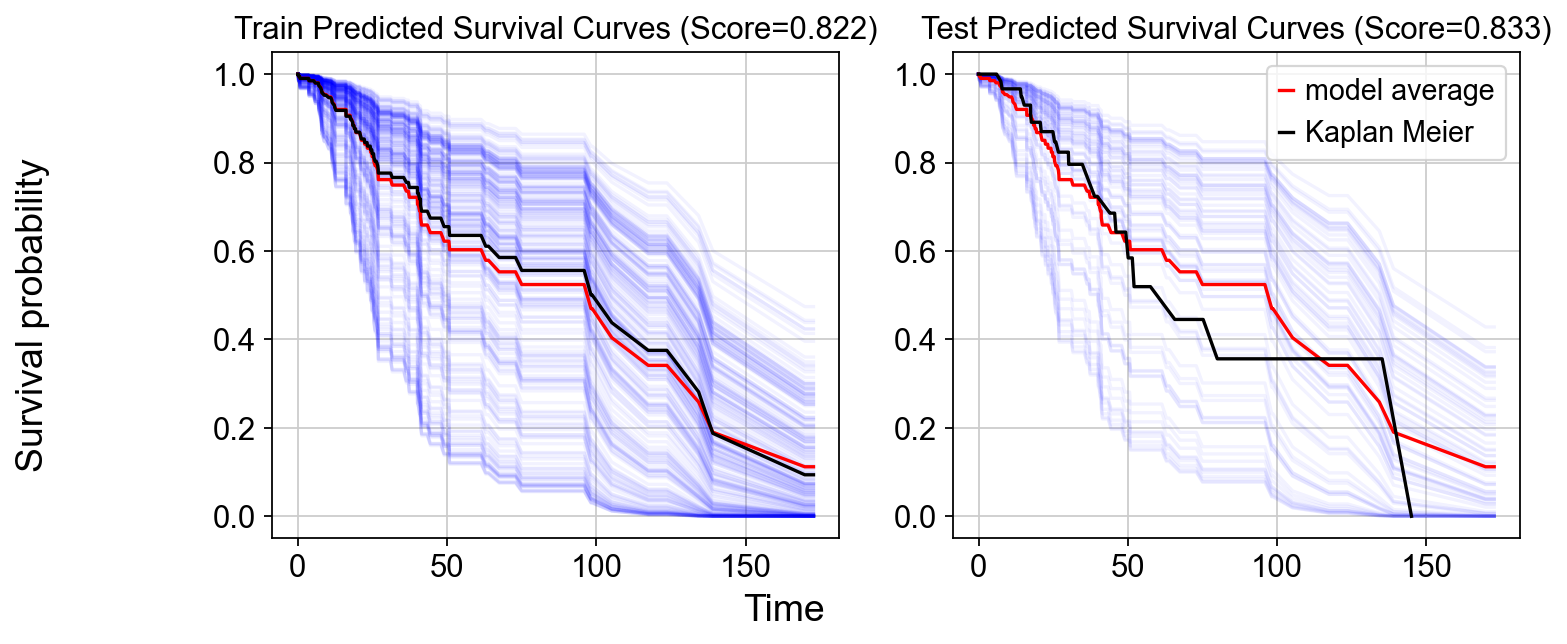

In [486]:
plot_surv_curves(X_train_pca, y_train_pca, X_test_pca, y_test_pca, cox_net2)

 Interpretation

Number of non-zero coefficients: 305


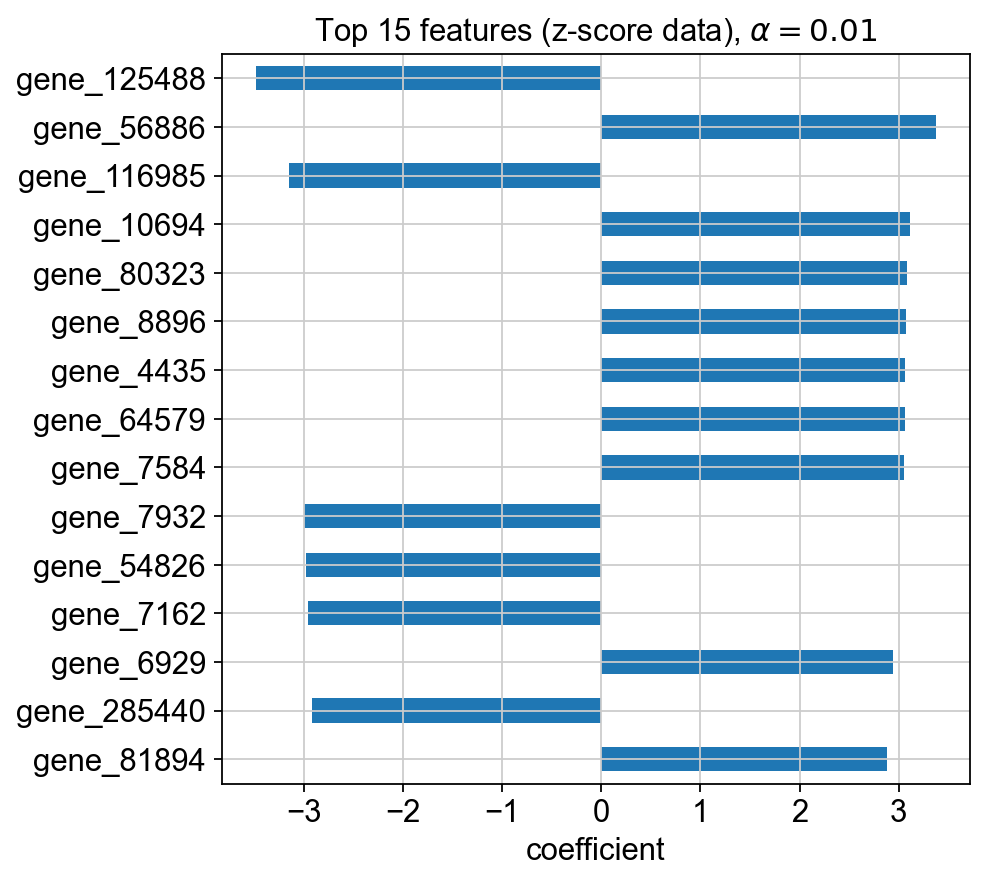

In [487]:
plot_coef(cox_net2, X.columns, proj=proj)

**Results are not good**

- The lead features are very different
- the choice of kernel matters a lot: RBF has good performance but shrinks to the mean, prefer polynomial
- This model seems very unstable
- the LASSO shrinkage does not happen

## Look at grouping patients

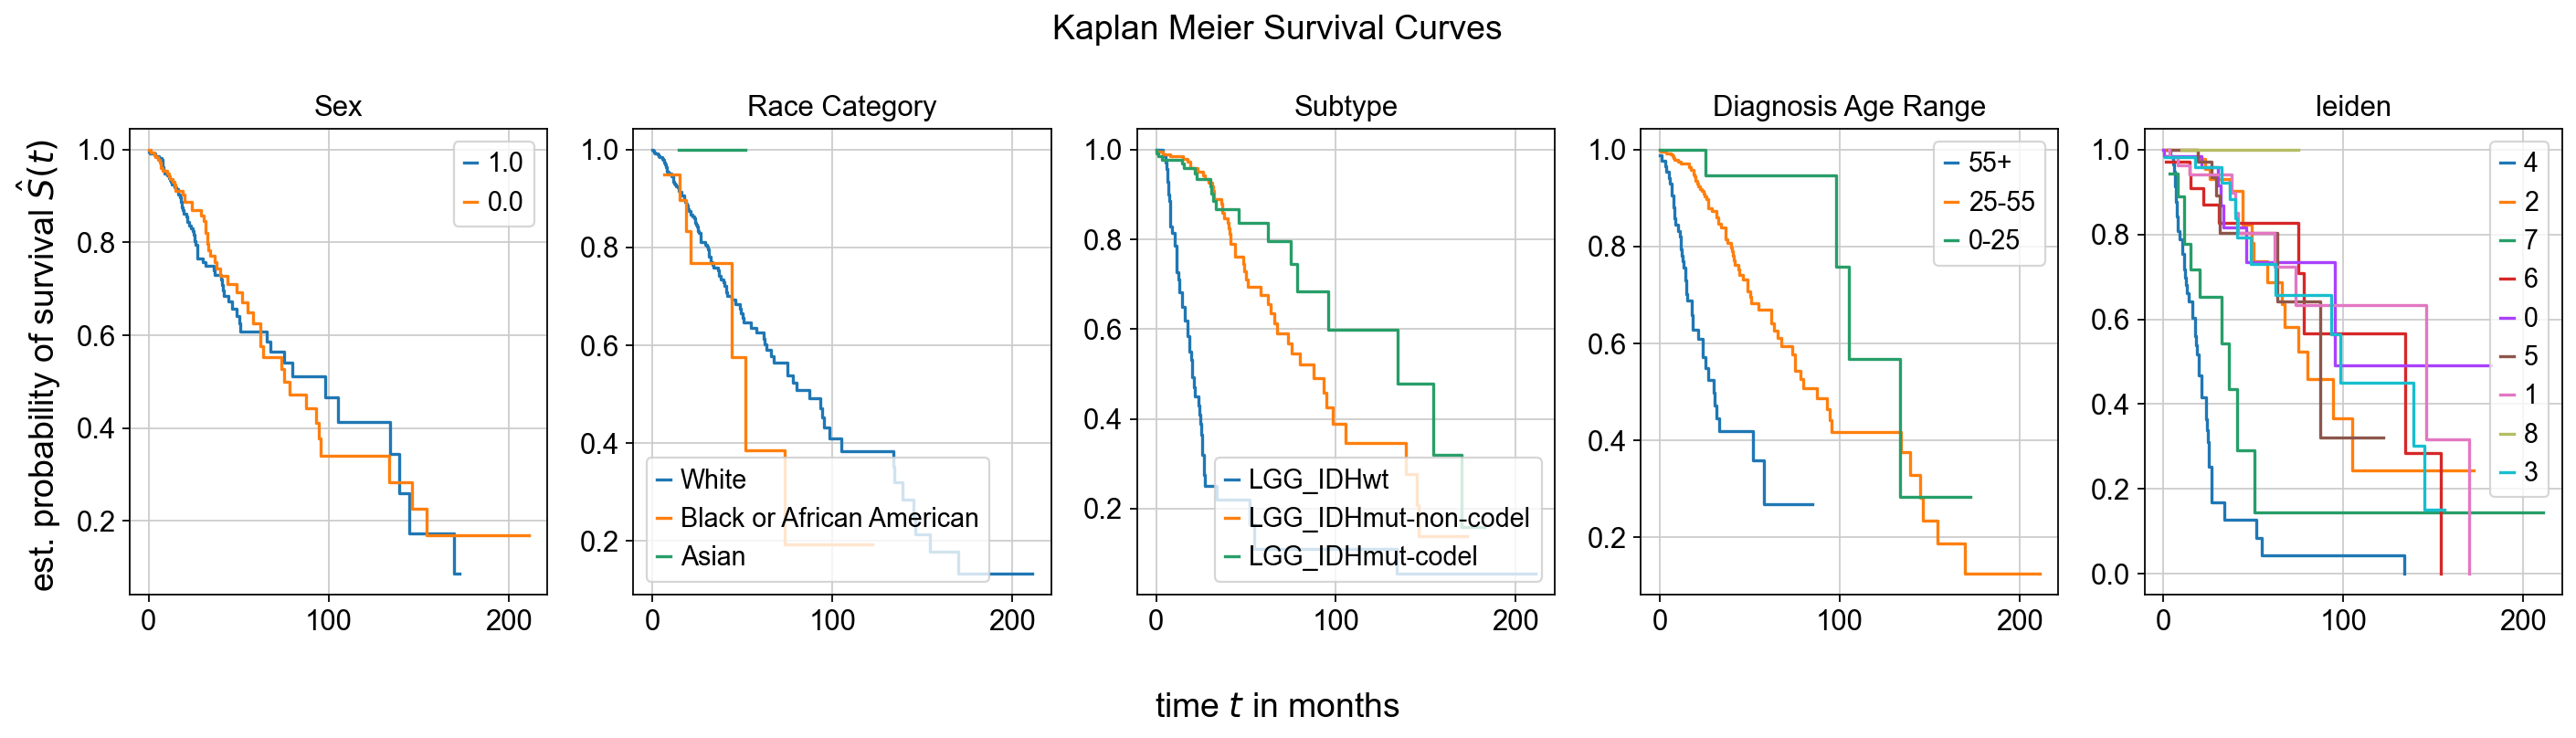

In [488]:
df = df_patient_clusters.dropna(axis=0).copy()

# define the age ranges and corresponding labels
age_ranges = [0, 25, 55, str('inf')]
age_labels = ['0-25', '25-55', '55+']
# use cut() function to create a new column with age ranges
df['Diagnosis Age Range'] = pd.cut(df['Diagnosis Age'], bins=age_ranges, labels=age_labels, include_lowest=True)

vars = ['Sex', 'Race Category', 'Subtype', 'Diagnosis Age Range', 'leiden']
n = len(vars)
fig, ax = plt.subplots(1,n, figsize=(18,5))
for i in range(n):
    var = vars[i]
    for value in df[var].unique():
        mask = df[var] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(df["Overall Survival Status"].astype(bool)[mask],
                                                            df["Overall Survival (Months)"][mask])        
        ax[i].step(time_cell, survival_prob_cell, where="post",
                   label=value)
        ax[i].set_title(f'{var}')
        ax[i].legend(loc="best")

fig.supylabel("est. probability of survival $\hat{S}(t)$")
fig.supxlabel("time $t$ in months")
fig.suptitle('Kaplan Meier Survival Curves')
plt.tight_layout()


Curves for Sex: 0.0


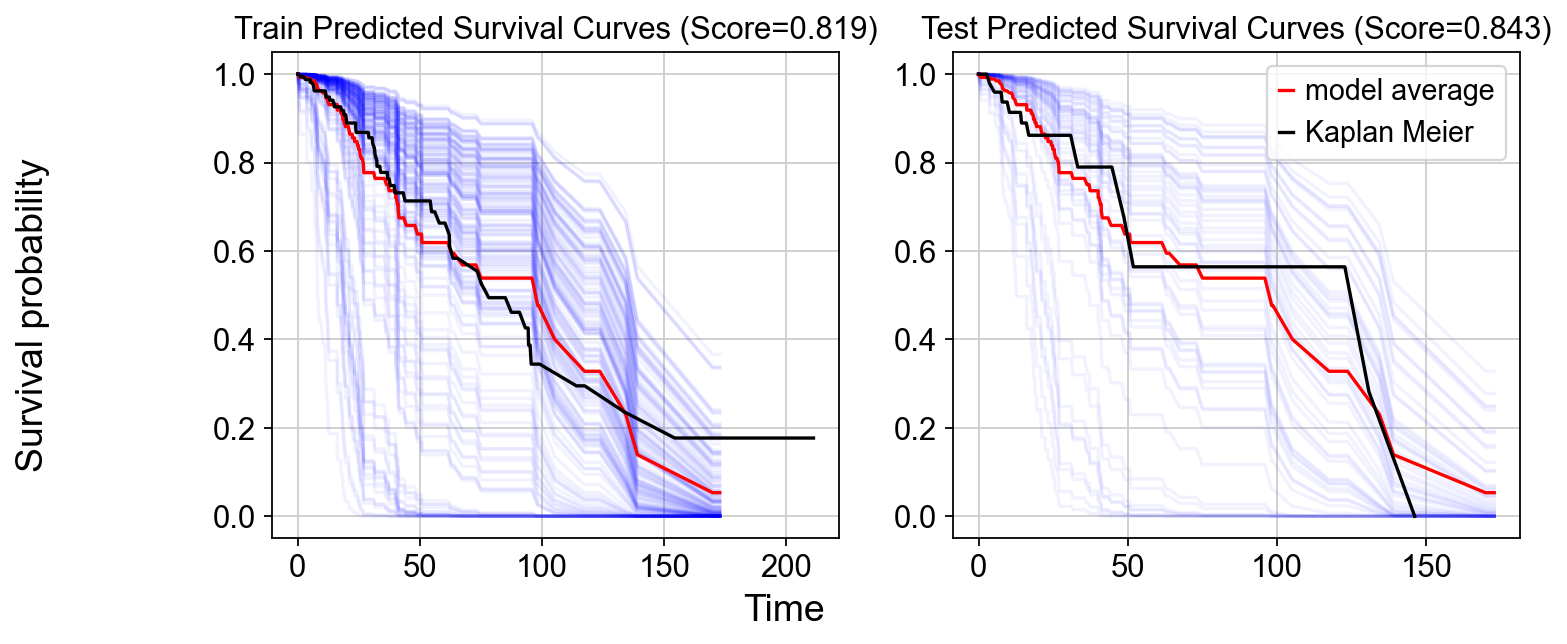

Curves for Sex: 1.0


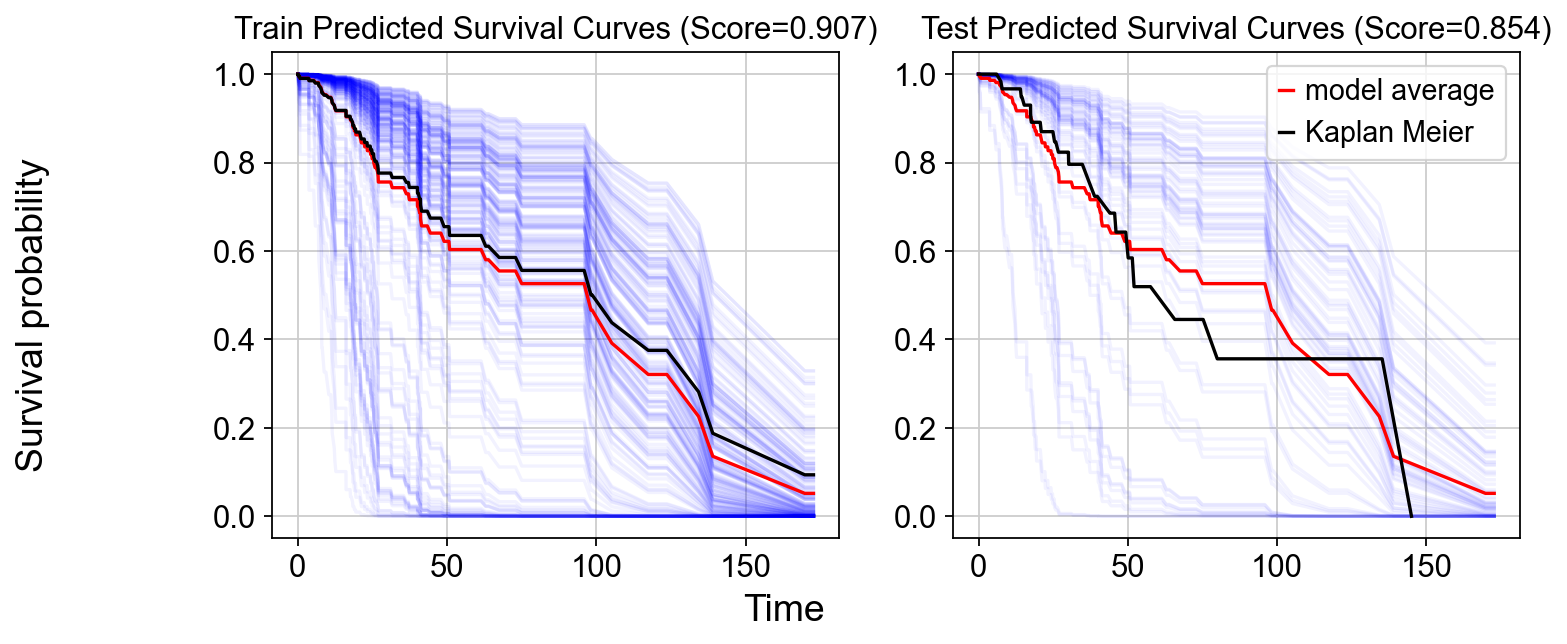

In [489]:
vars = ['Sex']
n = len(vars)

df = df_ML.copy()
for i in range(n):
    var = vars[i]
    for value in df[var].unique():
        mask = df[var] == value
        y_surv = pd.concat([df_ML['Overall Survival Status'][mask].astype(bool), 
                            df_ML['Overall Survival (Months)'][mask].apply(pd.to_numeric)],axis=1).to_records(index=False)

        X = df_ML[mask].drop(['Overall Survival Status', 'Overall Survival (Months)'], axis=1).reset_index(drop=True)
        X_surv=preproc(X)
        X_train, X_test, y_train, y_test = train_test_split(X_surv, y_surv, random_state=42)
        print(f'Curves for {var}: {value}')
        plot_surv_curves(X_train, y_train, X_test, y_test, cox_net)

  

# Automatic gene interpretation query

In [564]:
def get_gene_table(model,labels):
# list of gene IDs
    features = list(plot_coef(model, labels, return_results=True, plot=False, k=10)[1])

    # extract numerical characters from each element
    genes = []
    for element in features:
        # use regex to match digits (\d+)
        match = re.search(r'\d+', element)
        if match:
            genes.append(match.group())

    desc = []
    ids = []
    entrez_id_list = genes

    # email address to provide to NCBI
    Entrez.email = "your.email@example.com"

    # search for gene information for each ID
    for gene_id in entrez_id_list:
        print(gene_id)
        try:
            handle = Entrez.efetch(db="gene", id=str(gene_id), retmode="xml")
            record = Entrez.read(handle)
            handle.close()
            description = record[0]["Entrezgene_summary"]  
            #name = record[0]["Entrezgene_gene"]  
        except:
            description = 'NA'

        # print gene ID and description
        ids.append(gene_id)
        desc.append(description)

    return pd.DataFrame(list(zip(ids,desc)), columns=['ID','Description'])

In [565]:
biodf = get_gene_table(cox_net,X.columns)

8575
642
6929
6728
8861
55322
2015
378938


In [566]:
display(Markdown(biodf.to_markdown(index=False)))

|     ID | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
|-------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|   8575 | This gene encodes a protein kinase activated by double-stranded RNA which mediates the effects of interferon in response to viral infection. Mutations in this gene have been associated with dystonia. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Nov 2008]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|    642 | Bleomycin hydrolase (BMH) is a cytoplasmic cysteine peptidase that is highly conserved through evolution; however, the only known activity of the enzyme is metabolic inactivation of the glycopeptide bleomycin (BLM), an essential component of combination chemotherapy regimens for cancer. The protein contains the signature active site residues of the cysteine protease papain superfamily. [provided by RefSeq, Jul 2008]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
|   6929 | This gene encodes a member of the E protein (class I) family of helix-loop-helix transcription factors. E proteins activate transcription by binding to regulatory E-box sequences on target genes as heterodimers or homodimers, and are inhibited by heterodimerization with inhibitor of DNA-binding (class IV) helix-loop-helix proteins. E proteins play a critical role in lymphopoiesis, and the encoded protein is required for B and T lymphocyte development. Deletion of this gene or diminished activity of the encoded protein may play a role in lymphoid malignancies. This gene is also involved in several chromosomal translocations that are associated with lymphoid malignancies including pre-B-cell acute lymphoblastic leukemia (t(1;19), with PBX1), childhood leukemia (t(19;19), with TFPT) and acute leukemia (t(12;19), with ZNF384). Alternatively spliced transcript variants encoding multiple isoforms have been observed for this gene, and a pseudogene of this gene is located on the short arm of chromosome 9. [provided by RefSeq, Sep 2011] |
|   6728 | Enables 7S RNA binding activity. Contributes to ribosome binding activity. Predicted to be involved in SRP-dependent cotranslational protein targeting to membrane, signal sequence recognition. Located in nucleolus. Part of signal recognition particle, endoplasmic reticulum targeting. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
|   8861 | Enables LIM domain binding activity; RNA polymerase II-specific DNA-binding transcription factor binding activity; and enzyme binding activity. Involved in negative regulation of transcription, DNA-templated and positive regulation of transcription by RNA polymerase II. Located in chromatin. Part of beta-catenin-TCF complex. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
|  55322 | NA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|   2015 | This gene encodes a protein that has a domain resembling seven transmembrane G protein-coupled hormone receptors (7TM receptors) at its C-terminus. The N-terminus of the encoded protein has six EGF-like modules, separated from the transmembrane segments by a serine/threonine-rich domain, a feature reminiscent of mucin-like, single-span, integral membrane glycoproteins with adhesive properties. Multiple alternatively spliced transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Jan 2012]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 378938 | This gene produces a precursor transcript from which a long non-coding RNA is derived by RNase P cleavage of a tRNA-like small ncRNA (known as mascRNA) from its 3' end. The resultant mature transcript lacks a canonical poly(A) tail but is instead stabilized by a 3' triple helical structure. This transcript is retained in the nucleus where it is thought to form molecular scaffolds for ribonucleoprotein complexes. It may act as a transcriptional regulator for numerous genes, including some genes involved in cancer metastasis and cell migration, and it is involved in cell cycle regulation. Its upregulation in multiple cancerous tissues has been associated with the proliferation and metastasis of tumor cells. [provided by RefSeq, Mar 2015]                                                                                                                                                                                                                                                                                                           |